In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0" #restrict CUDA visibility

import cv2
import numpy as np
import random
import math
from PIL import Image
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
from diffusers import StableVideoDiffusionPipeline, AutoencoderKLTemporalDecoder, UNetSpatioTemporalConditionModel, EulerDiscreteScheduler
from diffusers.pipelines.stable_video_diffusion import StableVideoDiffusionPipelineOutput
from diffusers.models.unets.unet_spatio_temporal_condition import UNetSpatioTemporalConditionOutput
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.stable_video_diffusion.pipeline_stable_video_diffusion import _append_dims
from IPython.display import HTML

/home/luyi/miniconda3/envs/sgi2v/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/luyi/miniconda3/envs/sgi2v/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
"""
Define utils function
"""

def export_to_gif(
    video_frames, save_path
):
    """
    write to gif
    """
    if isinstance(video_frames[0], np.ndarray):
        video_frames = [(frame * 255).astype(np.uint8) for frame in video_frames]
    elif isinstance(video_frames[0], PIL.Image.Image):
        video_frames = [np.array(frame) for frame in video_frames]
    for i in range(len(video_frames)):
        video_frames[i] = Image.fromarray(video_frames[i])
    video_frames[0].save(save_path, save_all=True, append_images=video_frames[1:], loop=0, duration=110)
    return video_frames

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag
def tensor2vid(video, processor, output_type: str = "np"):
    #ref: https://github.com/huggingface/diffusers/blob/687bc2772721af584d649129f8d2a28ca56a9ad8/src/diffusers/pipelines/stable_video_diffusion/pipeline_stable_video_diffusion.py#L61C1-L79C19
    batch_size, channels, num_frames, height, width = video.shape
    outputs = []
    for batch_idx in range(batch_size):
        batch_vid = video[batch_idx].permute(1, 0, 2, 3)
        batch_output = processor.postprocess(batch_vid, output_type)
        outputs.append(batch_output)
    if output_type == "np":
        outputs = np.stack(outputs)
    elif output_type == "pt":
        outputs = torch.stack(outputs)
    elif not output_type == "pil":
        raise ValueError(f"{output_type} does not exist. Please choose one of ['np', 'pt', 'pil]")    
    return outputs
def visualize_control(image, trajectory_points):
    scale_factor = 1.5
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(trajectory_points)):
        frames = len(trajectory_points[i])
        for j in range(frames):
            source_point = trajectory_points[i][j]
            sx, sy, tx, ty = source_point[0], source_point[1], source_point[2], source_point[3]
            if j==0:
                image2 = cv2.rectangle(image.copy(), (int(sy), int(sx)), (int(ty), int(tx)), (69, 27, 255), thickness=-1)
                image = cv2.rectangle(image, (int(sy), int(sx)), (int(ty), int(tx)), (0, 0, 255), thickness=6)
                image2 = cv2.rectangle(image2, (int(sy), int(sx)), (int(ty), int(tx)), (0, 0, 255), thickness=6)
                image = cv2.addWeighted(image,0.4,image2,0.6,0)
            if j + 1 < frames:
                target_point = trajectory_points[i][j+1]
                sx2, sy2, tx2, ty2 = target_point[0], target_point[1], target_point[2], target_point[3]
                sx3 = (sx+tx)//2
                tx3 = (sx2+tx2)//2
                sy3 = (sy+ty)//2
                ty3 = (sy2+ty2)//2
                arrow_length = np.sqrt((sx3-tx3)**2 + (sy3-ty3)**2)
                green = (0,255,0)
                if j + 2 == frames:
                    image = cv2.line(image, (int(sy3), int(sx3)), (int(ty3), int(tx3)), green, thickness = int(12*scale_factor))
                    image = cv2.circle(image, (int(ty3), int(tx3)), radius = int(15*scale_factor), color = green, thickness = -1)
                    #image = cv2.arrowedLine(image, (int(sy3), int(sx3)), (int(ty3), int(tx3)), green, 12, tipLength=2) #8/arrow_length)
                else:
                    image = cv2.line(image, (int(sy3), int(sx3)), (int(ty3), int(tx3)), green, thickness = int(12*scale_factor)) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
def butterworth_low_pass_filter(latents, n=4, d_s=0.25):
    """
    Return the butterworth low pass filter mask.
    Modified from https://github.com/arthur-qiu/FreeTraj/blob/0b3ffdb932bba01ba707d689f4905c31b193468b/utils/utils_freetraj.py#L228
    """
    shape = latents.shape
    H, W = shape[-2], shape[-1]
    mask = torch.zeros_like(latents)
    if d_s==0:
        return mask
    for h in range(H):
        for w in range(W):
            d_square = ((2*h/H-1)**2 + (2*w/W-1)**2)
            mask[..., h,w] = 1 / (1 + (d_square / d_s**2)**n)
    return mask

In [3]:
"""
Define denoising network (UNet)
"""

class MyUNet(UNetSpatioTemporalConditionModel):
    """
    Modified from SVD implementation
    https://github.com/huggingface/diffusers/blob/24c7d578baf6a8b79890101dd280278fff031d12/src/diffusers/models/unets/unet_spatio_temporal_condition.py#L32
    """
    def inject(self):
        #Replace self-attention blocks in the upsampling layers with our implementation
        for (layer, upsample_block) in enumerate(self.up_blocks):
            if layer == 0: 
                continue
            for (sublayer, trans) in enumerate(upsample_block.attentions):
                basictrans = trans.transformer_blocks[0] #BasicTransformerBlock
                basictrans.attn1.processor = self.my_self_attention(layer, sublayer)

    record_value_ = []
    
    def forward(
        self,
        sample,
        timestep,
        encoder_hidden_states,
        added_time_ids,
        return_dict: bool = True,
    ):
        #Modified from the original implementation such that it cuts redundant computation during the optimization
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            is_mps = False
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        batch_size, num_frames = sample.shape[:2]
        timesteps = timesteps.expand(batch_size)
        t_emb = self.time_proj(timesteps)
        t_emb = t_emb.to(dtype=sample.dtype)
        emb = self.time_embedding(t_emb)
        time_embeds = self.add_time_proj(added_time_ids.flatten())
        time_embeds = time_embeds.reshape((batch_size, -1))
        time_embeds = time_embeds.to(emb.dtype)
        aug_emb = self.add_embedding(time_embeds)
        emb = emb + aug_emb
        sample = sample.flatten(0, 1)
        emb = emb.repeat_interleave(num_frames, dim=0)
        encoder_hidden_states = encoder_hidden_states.repeat_interleave(num_frames, dim=0)
        sample = self.conv_in(sample)
        image_only_indicator = torch.zeros(batch_size, num_frames, dtype=sample.dtype, device=sample.device)
        down_block_res_samples = (sample,)
        for layer, downsample_block in enumerate(self.down_blocks):
            if hasattr(downsample_block, "has_cross_attention") and downsample_block.has_cross_attention:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    encoder_hidden_states=encoder_hidden_states,
                    image_only_indicator=image_only_indicator,
                )
            else:
                sample, res_samples = downsample_block(
                    hidden_states=sample,
                    temb=emb,
                    image_only_indicator=image_only_indicator,
                )

            down_block_res_samples += res_samples
        sample = self.mid_block(
            hidden_states=sample,
            temb=emb,
            encoder_hidden_states=encoder_hidden_states,
            image_only_indicator=image_only_indicator,
        )
        for i, upsample_block in enumerate(self.up_blocks):
            if self.training and i > max(self.record_layer_sublayer)[0]:
                return None #skip redundant computation during optimization
            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]
            if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cross_attention:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    encoder_hidden_states=encoder_hidden_states,
                    image_only_indicator=image_only_indicator,
                )
            else:
                sample = upsample_block(
                    hidden_states=sample,
                    temb=emb,
                    res_hidden_states_tuple=res_samples,
                    image_only_indicator=image_only_indicator,
                )
        if self.training:
            return None #skip redundant computation during optimization
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)
        sample = sample.reshape(batch_size, num_frames, *sample.shape[1:])
        if not return_dict:
            return (sample,)
        return UNetSpatioTemporalConditionOutput(sample=sample)
    
    def my_self_attention(self, layer, sublayer):
        compress_factor = [None, 4, 2, 1][layer]
        #Modified from the original implementation so that we can record semantically aligned feature maps during the optimization
        def processor(
            attn,
            hidden_states,
            encoder_hidden_states = None,
            attention_mask = None,
            temb = None,
        ):
            residual = hidden_states

            h = self.latent_shape[-2]//compress_factor
            w = self.latent_shape[-1]//compress_factor
            
            input_ndim = hidden_states.ndim
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            query = attn.to_q(hidden_states)
            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            key = attn.to_k(encoder_hidden_states)
            value = attn.to_v(encoder_hidden_states)
            inner_dim = key.shape[-1]
            head_dim = inner_dim // attn.heads
            query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
            
            if self.training and ((layer, sublayer) in self.record_layer_sublayer):
                #Modified self-attention computation
                #inject key and value from the first frame to obtain semantically aligned fieature maps
                frame = query.shape[0]
                key2 = (key.reshape((1, frame)+key.shape[1:]))[:,:1].repeat((1,frame,1,1,1)).reshape(key.shape)
                value2 = (value.reshape((1, frame)+value.shape[1:]))[:,:1].repeat((1,frame,1,1,1)).reshape(value.shape)

                hidden_states = F.scaled_dot_product_attention(query, key2.clone().detach(), value2.clone().detach(), attn_mask=None, dropout_p=0.0, is_causal=False)
                hid = hidden_states.permute((0, 2, 1, 3)) #(2*batch, h*w, head, channel)
                hid = hid.reshape((hid.shape[0], h, w, -1))
                self.record_value_.append(hid)
            
            hidden_states = F.scaled_dot_product_attention(
                    query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
            )
            hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
            hidden_states = hidden_states.to(query.dtype)
            hidden_states = attn.to_out[0](hidden_states)
            hidden_states = attn.to_out[1](hidden_states)
            hidden_states = hidden_states / attn.rescale_output_factor
            return hidden_states
        return processor

In [4]:

"""
Define Pipeline
"""

class MyI2VPipe(StableVideoDiffusionPipeline):
    """
    Modified from the original SVD pipeline
    ref: https://github.com/huggingface/diffusers/blob/24c7d578baf6a8b79890101dd280278fff031d12/src/diffusers/pipelines/stable_video_diffusion/pipeline_stable_video_diffusion.py#L139
    """
    heatmap = {}
    def get_gaussian_heatmap(self, h, w):
        """
        Generate gaussian heatmap
        Modified from https://github.com/showlab/DragAnything/blob/main/demo.py#L380
        """
        if (h,w) in self.heatmap:
            isotropicGrayscaleImage = self.heatmap[(h,w)]
        else:
            sigy = self.unet.heatmap_sigma*(h/2)
            sigx = self.unet.heatmap_sigma*(w/2)

            cx = w/2
            cy = h/2
            isotropicGrayscaleImage = np.zeros((h, w), np.float32)
            for y in range(h):
                for x in range(w):
                    isotropicGrayscaleImage[y, x] = 1 / 2 / np.pi / (sigx*sigy) * np.exp(
                        -1 / 2 * ((x+0.5 - cx) ** 2 / (sigx ** 2) + (y+0.5 - cy) ** 2 / (sigy ** 2)))
            isotropicGrayscaleImage = (isotropicGrayscaleImage / np.max(isotropicGrayscaleImage)).astype(np.float32)
            self.heatmap[(h,w)] = isotropicGrayscaleImage
        return torch.from_numpy(isotropicGrayscaleImage).cuda()

    def __call__(
        self,
        image,
        trajectory_points,
        height,
        width,
        num_frames,
        min_guidance_scale=1.0,
        max_guidance_scale=3.0,
        fps=7,
        generator=None,
        motion_bucket_id=127,
        noise_aug_strength=0.02,
        decode_chunk_size=8,
    ):
        batch_size = 1
        fps = fps - 1
        self._guidance_scale = max_guidance_scale

        # —— 1. 原 notebook 的微弱加噪 Data Augmentation —— #
        image_embeddings = self._encode_image(
            image, "cuda", batch_size, self.do_classifier_free_guidance
        )
        try:
            image = self.image_processor.preprocess(
                image, height=height, width=width
            ).to("cuda")
        except:
            self.image_processor = self.video_processor
            image = self.image_processor.preprocess(
                image, height=height, width=width
            ).to("cuda")

        # —— **关键：与 notebook 完全一致的噪声注入** —— #
        noise = randn_tensor(
            image.shape, generator=generator,
            device=image.device, dtype=image.dtype
        ).to("cuda")
        image = image + noise_aug_strength * noise

        # —— 2. VAE 编码 & 时间 ID 等预处理 —— #
        needs_upcast = self.vae.dtype == torch.float16 and self.vae.config.force_upcast
        if needs_upcast:
            self.vae.to(torch.float32)
        image_latents = self._encode_vae_image(
            image, device="cuda", num_videos_per_prompt=1,
            do_classifier_free_guidance=self.do_classifier_free_guidance,
        ).to(image_embeddings.dtype)
        if needs_upcast:
            self.vae.to(torch.float16)
        image_latents = image_latents.unsqueeze(1).repeat(1, num_frames, 1, 1, 1)
        print(f"image latents shape: {image_latents.shape}")
        
        added_time_ids = self._get_add_time_ids(
            fps, motion_bucket_id, noise_aug_strength,
            image_embeddings.dtype, batch_size, 1,
            self.do_classifier_free_guidance,
        ).to("cuda")

        # —— 3. 初始化 Scheduler 与 Latents —— #
        self.scheduler.set_timesteps(self.unet.num_inference_steps, device="cuda")
        timesteps = self.scheduler.timesteps
        C = self.unet.config.in_channels
        
        shape = (
            batch_size, num_frames, C//2,
            height//self.vae_scale_factor,
            width//self.vae_scale_factor)
        
        latents = randn_tensor(
            shape, generator=generator,
            device=image.device, dtype=image_embeddings.dtype
        ).to("cuda")
        
        latents = latents * self.scheduler.init_noise_sigma
        self.unet.latent_shape = latents.shape

        # —— 4. Guidance Scale —— #
        guidance_scale = torch.linspace(
            min_guidance_scale, max_guidance_scale, num_frames
        ).unsqueeze(0).to("cuda", latents.dtype)
        guidance_scale = _append_dims(
            guidance_scale.repeat(batch_size,1),
            latents.ndim
        )
        self._guidance_scale = guidance_scale

        # —— 5. 释放显存 —— #
        self.vae.to("cpu")
        self.image_encoder.to("cpu")
        torch.cuda.empty_cache()

        # —— 6. Denoising 循环 + SG-I2V 高频替换 —— #
        with self.progress_bar(total=self.unet.num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # 更新当前 timestep 标志
                self.unet.cur_timestep = len(timesteps) - i

                print(f"latent shape: {latents.shape}")
                
                # —— 7) 构造 UNet 输入 & 预测 —— #
                latent_model_input = (
                    torch.cat([latents]*2) if self.do_classifier_free_guidance
                    else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )
                
                # test: what if no image latents
                latent_model_input = torch.cat(
                    [latent_model_input, image_latents], dim=2
                )
                
                
                # next experiment: 直接用原始 latents 作为 reference noise
                
                
                # —— 在指定 steps 上做注入 + FFT 高频替换 —— #
                if hasattr(self.unet, "optimize_latent_time") and self.unet.cur_timestep in self.unet.optimize_latent_time:
                    print(f"Injecting at timestep {self.unet.cur_timestep}...")
                    # 1) 保存原版 latents 备后做 FFT
                    original_latents = latent_model_input.clone()

                    # 2) 计算 α
                    K   = len(self.unet.optimize_latent_time)
                    idx = self.unet.optimize_latent_time.index(self.unet.cur_timestep)
                    alpha = idx / max(K-1, 1)

                    # 3) 准备 reference noise
                    # ref = original_latents[:, 0]  # shape (B, C, H, W)
                    ref = original_latents[:, 0, :, :, :]

                    # 4) 对每一帧做 Gaussian heatmap 注入
                    bboxes = trajectory_points[0]
                    H = latent_model_input.shape[3]    # 72
                    W = latent_model_input.shape[4]    # 128
                    
                    for frame_idx in range(1, num_frames):
                        # 4.1 读取并下采样 bbox
                        frame_bbox = bboxes[frame_idx]
                        import math
                        x_min_f, y_min_f, x_max_f, y_max_f = [c / self.vae_scale_factor for c in frame_bbox]
                        x0 = math.floor(x_min_f)
                        x1 = math.ceil (x_max_f)
                        y0 = math.floor(y_min_f)
                        y1 = math.ceil (y_max_f)

                        # clamp 到合法范围 [0, W], [0, H]
                        x0 = max(0, min(x0, W-1))
                        x1 = max(1, min(x1, W  ))  # 保证至少有 1 列
                        y0 = max(0, min(y0, H-1))
                        y1 = max(1, min(y1, H  ))  # 保证至少有 1 行

                        # 重新计算切片尺寸
                        h_box = y1 - y0
                        w_box = x1 - x0

                        # 如果真的非常小，可以选择跳过这一帧的 injection
                        if h_box <= 0 or w_box <= 0:
                            print(f"Skipping frame {frame_idx} due to invalid bbox size: {h_box}, {w_box}")
                            continue
                        
                        # 4.2 生成子热图并贴到大热图
                        sub_hmap = self.get_gaussian_heatmap(h_box, w_box)  # (h_box, w_box)
                        sub_hmap = sub_hmap[None,None]                      # (1,1,h_box,w_box)

                        # normalize the heatmap to [0, 1]
                        sub_hmap = (sub_hmap - sub_hmap.min()) / (sub_hmap.max() - sub_hmap.min() + 1e-8)
                        
                        hmap = torch.zeros(1,1,H,W, device=latent_model_input.device, dtype=latent_model_input.dtype)
                        # hmap[:,:, y0:y1, x0:x1] = sub_hmap
                        hmap[:,:, y0:y1, x0:x1] = 1

                        # 4.3 权重混合
                        curr = latent_model_input[:, frame_idx, :, :, :]
                        fused = hmap * ref + (1 - hmap) * curr
                        latent_model_input[:, frame_idx, :, :, :] = fused # alpha * fused + (1 - alpha) * curr

                    # —— 2) SG-I2V 风格的 FFT 高频替换 —— #
                    if getattr(self.unet, "latent_fft_post_merge", False):
                        fft_axis = (-2, -1)
                        with torch.no_grad():
                            # 1) 暂时切换到 float32
                            lat_fp32  = latent_model_input.to(torch.float32)
                            orig_fp32 = original_latents.to(torch.float32)

                            # 2) 低通掩码也用 float32
                            LPF = butterworth_low_pass_filter(lat_fp32, d_s=self.unet.latent_fft_ratio)

                            # 3) FFT / shift
                            lat_f  = torch.fft.fftn (lat_fp32,  dim=fft_axis)
                            lat_f  = torch.fft.fftshift(lat_f, dim=fft_axis)
                            orig_f = torch.fft.fftn (orig_fp32, dim=fft_axis)
                            orig_f = torch.fft.fftshift(orig_f, dim=fft_axis)

                            # 4) 高频低频混合
                            HPF    = 1 - LPF
                            new_f  = lat_f * LPF + orig_f * HPF

                            # 5) ifftshift + iFFT
                            new_f = torch.fft.ifftshift(new_f, dim=fft_axis)
                            lat_ifft = torch.fft.ifftn(new_f, dim=fft_axis).real

                            # 6) cast 回原来的 dtype
                            latent_model_input = lat_ifft.to(latent_model_input.dtype)
                
                print(f"latent_model_input shape: {latent_model_input.shape}")
                print(f"image embeddings shape: {image_embeddings.shape}")
                
                with torch.no_grad():
                    noise_pred = self.unet(
                        latent_model_input, t,
                        encoder_hidden_states=image_embeddings,
                        added_time_ids=added_time_ids,
                        return_dict=False,
                    )[0]
                if self.do_classifier_free_guidance:
                    un, co = noise_pred.chunk(2)
                    noise_pred = un + self._guidance_scale * (co - un)

                # —— 8) Scheduler 更新 latents —— #
                latents = self.scheduler.step(
                    noise_pred, t, latents, s_churn=0.0
                ).prev_sample

                # 更新进度条
                if (i+1) % self.scheduler.order == 0 or i == len(timesteps)-1:
                    progress_bar.update()

        # —— 9. 解码 & 返回 —— #
        self.vae.to("cuda")
        self.image_encoder.to("cuda")
        if needs_upcast:
            self.vae.to(torch.float16)
        frames = self.decode_latents(latents, num_frames, decode_chunk_size)
        frames = tensor2vid(frames, self.image_processor, output_type="np")
        self.maybe_free_model_hooks()
        return StableVideoDiffusionPipelineOutput(frames=frames)

In [5]:
class Config:
    """
    Hyperparameters
    """
    seed = 817
    height, width = 576, 1024 #resolution of generated video
    num_frames = 14
    num_inference_steps = 50 #total number of inference steps
    optimize_latent_time = list(range(20,49)) #set of timesteps to perform optimization
    record_layer_sublayer = [(2, 1), (2, 2)] #extract feature maps from 1st and 2nd self-attention (note: 0-indexed base) located at 2nd resolution-level of upsampling layer
    heatmap_sigma = 0.4 #standard deviation of gaussian heatmap
    fft_ratio = 0.5 #fft mix ratio
    latent_fft_post_merge = True #fft-based post-processing is enabled iff True

config = Config()


In [6]:

# Load and set up the pipeline
svd_dir = "stabilityai/stable-video-diffusion-img2vid"
cache_dir = "/home/luyi/luyi_workspace/SG-I2V/generation_cache/"
# clear cache_dir
# import shutil
# if os.path.exists(cache_dir):
#     shutil.rmtree(cache_dir)
# os.makedirs(cache_dir, exist_ok=True)
    
feature_extractor = CLIPImageProcessor.from_pretrained(svd_dir, subfolder="feature_extractor", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16")
vae = AutoencoderKLTemporalDecoder.from_pretrained(svd_dir, subfolder="vae", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
requires_grad(vae, False)
image_encoder = CLIPVisionModelWithProjection.from_pretrained(svd_dir, subfolder="image_encoder", cache_dir = cache_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
requires_grad(image_encoder, False)
unet = MyUNet.from_pretrained(svd_dir, subfolder="unet", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16").to("cuda")
requires_grad(unet, False)
scheduler = EulerDiscreteScheduler.from_pretrained(svd_dir, subfolder="scheduler", cache_dir=cache_dir, torch_dtype=torch.float16, variant="fp16")
        
# unet.inject() #inject module
    
#Set up pipeline
pipe = MyI2VPipe(vae,image_encoder,unet,scheduler,feature_extractor).to(device="cuda")

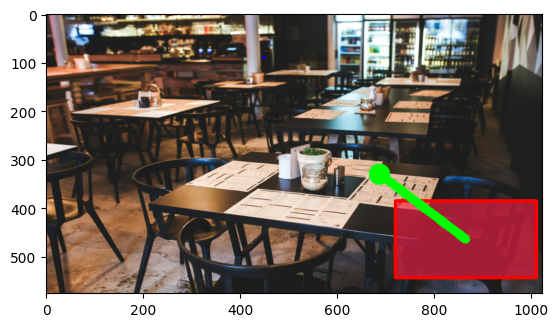

In [7]:

# read npy file
import numpy as np
ID = 176

image_path = f"/home/luyi/luyi_workspace/SG-I2V/examples/{ID}/img.png"
file_path = f"/home/luyi/luyi_workspace/SG-I2V/examples/{ID}/traj.npy"
data = np.load(file_path, allow_pickle=True)

data = [data[1]]  # 读取第一个对象的轨迹数据

# load image
image = Image.open(image_path).convert('RGB')
image = image.resize((config.width, config.height))

# 处理轨迹数据
trajectory_points = []  # N x frames x 4

# 遍历每个对象
for obj_idx in range(len(data)):
    obj_data = data[obj_idx]
    
    # 获取边界框坐标 (前两行)
    box_tl = obj_data[0]  # top-left [w1, h1]
    box_br = obj_data[1]  # bottom-right [w2, h2]
    
    # 获取轨迹数据 (从第三行开始)
    center_points = obj_data[2:]
    
    # 创建当前对象的边界框轨迹
    box_traj = []
    
    # 对每一帧
    for frame_idx in range(len(center_points)):
        # 获取当前中心点
        curr_center = center_points[frame_idx]
        
        # 计算相对于第一帧的偏移量
        if frame_idx == 0:
            dx, dy = 0, 0  # 第一帧无偏移
        else:
            dx = center_points[frame_idx][0] - center_points[0][0]
            dy = center_points[frame_idx][1] - center_points[0][1]
        
        # 计算当前帧的边界框坐标 [top, left, bottom, right]
        curr_box = np.array([
            box_tl[1] + dy,      # top = h1 + dy
            box_tl[0] + dx,      # left = w1 + dx
            box_br[1] + dy,      # bottom = h2 + dy
            box_br[0] + dx       # right = w2 + dx
        ], dtype=np.float32)
        
        box_traj.append(curr_box)
    
    # 添加到总轨迹列表
    trajectory_points.append(box_traj)

# 可视化
visualize_control(image, trajectory_points=trajectory_points)

In [ ]:
#Approx. 4 minutes on A6000 with default config
def run(config, image, trajectory_points, save_path):
    """
    Set up hyperparameters
    """
    pipe.unet.num_inference_steps = config.num_inference_steps
    pipe.unet.optimize_zero_initialize_param = True
    height, width = config.height, config.width
    motion_bucket_id = 127
    fps = 7
    num_frames = config.num_frames
    seed = config.seed
    pipe.unet.heatmap_sigma = config.heatmap_sigma
    pipe.unet.latent_fft_post_merge = config.latent_fft_post_merge
    pipe.unet.latent_fft_ratio = config.fft_ratio #range : 0.0 - 1.0
    pipe.unet.optimize_latent_time = config.optimize_latent_time
    pipe.unet.record_layer_sublayer =  config.record_layer_sublayer
    generator = torch.manual_seed(seed)
    frames = pipe(image, trajectory_points, height=height, width=width, num_frames = num_frames, decode_chunk_size=8, generator=generator, fps=fps, motion_bucket_id=motion_bucket_id, noise_aug_strength=0.02).frames[0]
    #save video
    export_to_gif(frames, save_path)

#generate video
run(config, image, trajectory_points, save_path="./result.gif")
HTML("<img src=\"" + "./result.gif" + "\">")

image latents shape: torch.Size([2, 14, 4, 72, 128])


  0%|          | 0/50 [00:00<?, ?it/s]

latent shape: torch.Size([1, 14, 4, 72, 128])
latent_model_input shape: torch.Size([2, 14, 8, 72, 128])
image embeddings shape: torch.Size([2, 1, 1024])


  2%|▏         | 1/50 [00:01<01:19,  1.63s/it]

latent shape: torch.Size([1, 14, 4, 72, 128])
latent_model_input shape: torch.Size([2, 14, 8, 72, 128])
image embeddings shape: torch.Size([2, 1, 1024])


  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

latent shape: torch.Size([1, 14, 4, 72, 128])
Injecting at timestep 48...
latent_model_input shape: torch.Size([2, 14, 8, 72, 128])
image embeddings shape: torch.Size([2, 1, 1024])


  6%|▌         | 3/50 [00:04<01:16,  1.64s/it]

latent shape: torch.Size([1, 14, 4, 72, 128])
Injecting at timestep 47...
latent_model_input shape: torch.Size([2, 14, 8, 72, 128])
image embeddings shape: torch.Size([2, 1, 1024])


  8%|▊         | 4/50 [00:06<01:17,  1.69s/it]


latent shape: torch.Size([1, 14, 4, 72, 128])
Injecting at timestep 46...
latent_model_input shape: torch.Size([2, 14, 8, 72, 128])
image embeddings shape: torch.Size([2, 1, 1024])


KeyboardInterrupt: 

: 